In [1]:
# Lets build an overall generation pipeline
# We first start by loading three models: The ToxicityRegressor, PersonalizedDrugResponse predictor and the 
# infilling generator model
# We then build a pipeline that calls these models iteratively to determine pareto optimal drugs.

In [1]:
from tdc.multi_pred import DrugRes
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
import sys
import torch
import numpy as np
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from rdkit import Chem
import pandas as pd

sys.path.append('D:\\My Documents\\projects\\drug\\')
sys.path.append("D:\My Documents\projects\drug\st\smiles_transformer")
# Load the model code
from Toxicity.DeepToxRegressor import DeepToxRegressor 
from Toxicity.ToxicityDataset import ToxicityDataset 

from response.DeepPerDrug import PersonalizedDrugResModel
from response.DrugRespDataset import DrugRespDataset

from st.smiles_transformer.utils import split as split_method
from st.smiles_transformer.build_vocab import WordVocab
data = DrugRes(name = 'GDSC1') 
# Load entire dataset into "train" split
split = data.get_split(method = 'random', seed = 42, frac = [1.0,0, 0])

seq_len = 128

vocab = WordVocab.load_vocab('D:\My Documents\projects\drug\st\smiles_transformer\data\chembl_vocab.pkl')


Found local copy...
Loading...
Done!


In [3]:
m = PersonalizedDrugResModel(len(vocab.stoi),embed_dim=64,seq_len = 128, numRNA_features=17737,mRNA_proj_dim=512, dropout=0.75)  
m.load_state_dict(torch.load("response\drug_resp_model_gdsc1.pt"))
m = m.cuda()
m.eval()


PersonalizedDrugResModel(
  (emb): Embedding(50, 64)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=16, bias=True)
  (lin3): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (dropoutSm): Dropout(p=0.1, inplace=False)
  (layernormSmiles): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (layernormRNA): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (mRNAProjLayer1): Linear(in_features=17737, out_features=512, bias=True)
  (mRNAProjLayer2): Linear(in_features=512, out_features=1024, bias=True)
  (FinalLayer1): Linear(in_features=2048, out_features=128, bias=True)
  (FinalLayer2): Linear(in_features=128, out_features=64, bias=True)
  (FinalLayer3): Linear(in_features=64, out_features=32, bias=True)
  (FinalLayer4): Linear(in_features=32, out_features=1, bias=True)
)

In [4]:
# Now let us load the toxicity model and verify that it works correctly
mTox = DeepToxRegressor(len(vocab.stoi),embed_dim=64) 
mTox.load_state_dict(torch.load('Toxicity\\toxicity_predictor_herG.pt'))

mTox = mTox.cuda()
mTox.eval()
print(mTox)

DeepToxRegressor(
  (emb): Embedding(50, 64)
  (lin1): Linear(in_features=64, out_features=256, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (SmilesProjLayer): Linear(in_features=32768, out_features=64, bias=True)
  (CombinedLayer1): Linear(in_features=64, out_features=32, bias=True)
  (CombinedLayer2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [5]:
import sys
import torch
sys.path.append('D:\\My Documents\\projects\\drug\\')
custom_vocab_fp='D:\\My Documents\\projects\\drug\\st\smiles_transformer\data\chembl_vocab.csv'
from nanoGPT.model import GPTConfig, GPT
from st.smiles_transformer.utils import split as split_method

MODEL_DIR = 'train_smiles'
MASK_CLS = 'ilm.mask.custom.MaskSmiles'

# load pretrained model
block_size = 256 # context of up to 256 previous characters
n_layer = 5
n_head = 8
n_embd = 128
dropout = 0.2
bias = False
vocab_size=53

# Prepare tokenizer

import os
import pickle

import ilm.tokenize_util
tokenizer = ilm.tokenize_util.Tokenizer['CUSTOM']
ilm.tokenize_util.set_custom_vocab_fp(custom_vocab_fp)
#tokenizer = ilm.tokenize_util.Tokenizer.GPT2
with open(os.path.join(MODEL_DIR, 'D:\\My Documents\\projects\\drug\\ilm\\train_smiles\\additional_ids_to_tokens.pkl'), 'rb') as f:
    additional_ids_to_tokens = pickle.load(f)
additional_tokens_to_ids = {v:k for k, v in additional_ids_to_tokens.items()}
try:
    ilm.tokenize_util.update_tokenizer(additional_ids_to_tokens, tokenizer)
except ValueError:
    print('Already updated')
print(additional_tokens_to_ids)


model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                bias=bias, vocab_size=vocab_size, dropout=dropout) # start with model_args from command line

gptconf = GPTConfig(**model_args)
mGen = GPT(gptconf)
mGen.load_state_dict(torch.load('D:\\My Documents\\projects\\drug\\ilm\\train_smiles\\model.pt'))

# Load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mGen.eval()
_ = mGen.to(device)

def getModelNumParams(myModel):
    total_params = sum(p.numel() for p in myModel.parameters())
    return total_params

State (['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'c', 'C', '(', ')', 'O', '1', '2', '=', 'N', '@', '[', ']', 'n', '3', 'H', '4', 'F', '-', 'S', 'Cl', '/', 's', 'o', '5', '+', '.', '#', 'Br', '\\', 'P', '6', 'I', '7', 'Na', '-2', '-3', '8', 'B', '9', 'Si', '%10', 'K', '%11', '-4', 'Se'], {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3, '<mask>': 4, 'c': 5, 'C': 6, '(': 7, ')': 8, 'O': 9, '1': 10, '2': 11, '=': 12, 'N': 13, '@': 14, '[': 15, ']': 16, 'n': 17, '3': 18, 'H': 19, '4': 20, 'F': 21, '-': 22, 'S': 23, 'Cl': 24, '/': 25, 's': 26, 'o': 27, '5': 28, '+': 29, '.': 30, '#': 31, 'Br': 32, '\\': 33, 'P': 34, '6': 35, 'I': 36, '7': 37, 'Na': 38, '-2': 39, '-3': 40, '8': 41, 'B': 42, '9': 43, 'Si': 44, '%10': 45, 'K': 46, '%11': 47, '-4': 48, 'Se': 49}) {50: '<|startofinfill|>', 51: '<|endofinfill|>', 52: '<|infill_element|>'}
['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'c', 'C', '(', ')', 'O', '1', '2', '=', 'N', '@', '[', ']', 'n', '3', 'H', '4', 'F', '-', 'S', 'Cl', '/', 's'

In [6]:
# Now let us create a list of candidate drugs
# Start with the GDSC1 drugs
df = split['train']
print(df.head())
print(len(df))
# This was important as the dataset is very structured!
df_drug = df.sample(10000, random_state=33)
print(len(df_drug))
drug_candidates_source = list(set(df_drug['Drug']))
print(len(drug_candidates_source))

cell_ID = set(df_drug['Cell Line_ID'])
print(len(cell_ID))
cell_line_list =[]
cell_ID = list(cell_ID)
for cell in cell_ID:
   # print(cell)
    df_subset = df_drug[df_drug['Cell Line_ID']==cell]
    cell_line_list.append((df_subset.iloc[0]['Cell Line']))
    
print(len(cell_line_list), len(cell_ID))
d = {'Cell Line_ID':cell_ID, 'Cell Line': cell_line_list}
df_cell_line = pd.DataFrame(data=d)
print(df_cell_line.head())

df_cell_line.to_csv('gdsc1_cell_line.csv')

     Drug_ID                                               Drug Cell Line_ID  \
0  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...       MC-CAR   
1  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES3   
2  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES5   
3  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES7   
4  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...        EW-11   

                                           Cell Line         Y  
0  [3.23827250519154, 2.98225419469807, 10.235490...  2.395685  
1  [8.690197905033282, 3.0914731119366, 9.9924871...  3.140923  
2  [8.233101127037282, 2.82468731112752, 10.01588...  3.968757  
3  [8.33346622426757, 3.9667571228514302, 9.79399...  2.692768  
4  [8.39134072442845, 2.9683601858810698, 10.2606...  2.478678  
177310
10000
208
953
953 953
  Cell Line_ID                                          Cell Line
0    NCI-H1836  [7.510331194584871

In [7]:
import numpy as np
# From stack overflow
# We assume that all costs are to be minimized

# Very slow for many datapoints.  Fastest for many costs, most readable
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient


In [8]:
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt
import random
from ilm.infer_smiles import infill_with_ilm
from tqdm import tqdm

class MediSeeker(object):
    def __init__(self, mTox, mIC50, mGen, cell_line_names, num_drug_candidates_per_cell_line, smiles_batch_size, smiles_vocab):
        self.topN = num_drug_candidates_per_cell_line
        self.pareto_dict={}
        self.mTox = mTox
        self.mIC50 = mIC50
        self.mGen = mGen
        self.num_mutations = 2
        self.num_new_samples_per_drug = 4
        self.smiles_batch_size = smiles_batch_size
        self.vocab = smiles_vocab
        for cell_line in cell_line_names:
            self.pareto_dict[cell_line] = {}
        print("Initialized MediSeeker Pipeline..")
        print("Loading models...")

        print("Toxicity Model: Number of parameters: {:3.3} million".format(getModelNumParams(self.mTox)/1e6))
        print("IC50 Model: Number of parameters: {:3.3} million".format(getModelNumParams(self.mIC50)/1e6))
        print("Generation Model: Number of parameters: {:3.3} million".format(getModelNumParams(self.mGen)/1e6))
        print(f"Number of cell-lines: {len(cell_line_names)}")
    
    def prepare_drug_data(self, drug_candidates):
        ''' List of drug candidates (for now we try this for all cell lines)'''
        smiles_data = SmilesDataset(drug_candidates, self.vocab)
        smiles_sampler = SequentialSampler(smiles_data)
        smiles_batch_size=self.smiles_batch_size
        smiles_dl = DataLoader(smiles_data, sampler=smiles_sampler, batch_size=self.smiles_batch_size, drop_last=True)
        return smiles_dl

    def predict_herg_IC50(self, smiles_dl, cell_line_dl):
        """
         Returns results[CellLineID][smiles_string] = IC50
         and herg_resp[smiles_string] = herg_inhibition (positive values are better)
        """
        herg_resp={}
        for sm_str,sm in smiles_dl:
                herg_estimate = self.mTox(sm.cuda())
                for s, e in zip(sm_str, herg_estimate):
                    herg_resp[s] = 200*e.cpu().item() # Convert to percentage

        results={}
        for idx, (cellID, g) in enumerate(tqdm(cell_line_dl)):
                g = g.repeat(smiles_batch_size,1)
                results[cellID[0]]={}
                for sm_str,sm in (smiles_dl):
                    sm=sm.cuda()
                    g = g.cuda().float()
                   # print(sm.size(), g.size())
                    output = self.mIC50(sm, g)
                   # print(output)
                    for sm_s, op in zip(sm_str, output):
                        results[cellID[0]][sm_s] = op.cpu().item()
        print("Computed hERG Toxicity response")
        print("Computed personalized IC50 prediction")

        return herg_resp, results
                
    def getSortedCandidates(self, herg_resp, results):
        candidate_dict={}
        for idx,cell_line in enumerate(results):
                #print(key, results[key])
                results[cell_line] = OrderedDict(sorted(results[cell_line].items(), key=lambda item: item[1], reverse=False))
                #print(cell_line)
                drug_IC50_dict = results[cell_line]
                candidate_dict[cell_line] =OrderedDict()
                for sm_str in list(drug_IC50_dict.keys())[0:self.topN]:
                      #print(k, herg_resp[k], d[k])
                      # Why -? This is because, we want herg_resp to be as large as possible +10 means the herG pathway is doing
                      # even better. So we want to pick a herg_resp that is a large positive. Later we will assume
                      # that all costs have to be minimized, so we negate herg_resp
                    candidate_dict[cell_line][sm_str]=(-herg_resp[sm_str],drug_IC50_dict[sm_str])
                    
        return candidate_dict
            
    def updateParetoPoints(self, candidate_dict):
        '''
        Returns a dict of cellLineID: smiles on pareto
        '''
        total_dict={}
        numParetoPoints = 0
        for cell_line in candidate_dict:
            candidate_dict[cell_line].update(self.pareto_dict[cell_line])
            d = candidate_dict[cell_line].keys()
            v = list(candidate_dict[cell_line].values())
            #plt.scatter(*zip(*v))
            #plt.show()
            is_efficient = is_pareto_efficient(np.array(v))
           # print(is_efficient)
            drug2 = np.array(list(d))
            pareto_drug = drug2[is_efficient]
            self.pareto_dict[cell_line] ={}
            for idx,drug in enumerate(pareto_drug):
                    self.pareto_dict[cell_line][drug] = candidate_dict[cell_line][drug]
                
        # Sort the pareto dicts for plotting
        for cell_line in self.pareto_dict:
            self.pareto_dict[cell_line] = OrderedDict(sorted(self.pareto_dict[cell_line].items(), key=lambda item: item[1][0], reverse=False))
            numParetoPoints+=len(set(self.pareto_dict[cell_line].keys()))
        print("Found a total of {0} pareto points".format(numParetoPoints))
            
    def getParetoPoints(self):
        return self.pareto_dict
    
    def generateNewDrugs(self):
        new_drug_dict={}
        source_dict={}
        for cell_line in self.pareto_dict:
            new_drug_dict[cell_line] = []
            source_dict[cell_line]=[]
            for cnt, drug in enumerate(self.pareto_dict[cell_line]):
                if cnt < 2:
                    ref = drug
                    context = split_method(ref.strip()).split()
                    L =len(context)
                    aList = list(range(L))
                    num_new_samples = 0
                    valid_samp={}
                    num_runs = 0
                    ref_sampled=0
                    num_fills = 32
                    sampled_list = random.sample(aList, self.num_mutations)

                    while (num_new_samples < self.num_new_samples_per_drug):
                        num_runs+=num_fills
                        if num_runs > 128:
                            #print("Sampling")
                            sampled_list = random.sample(aList, self.num_mutations)
                            context = split_method(ref.strip()).split()
                            #print(sampled_list)
                            num_runs = 0
                        # Change just k locations
                        for pos in sampled_list:
                            context[pos]='<mask>'

                        context_ids = ilm.tokenize_util.encode(context, tokenizer)
                        # Replace blanks with appropriate tokens from left to right
                        _blank_id = ilm.tokenize_util.encode(['<mask>'], tokenizer)[0]
                        #print(_blank_id)
                        for pos in sampled_list:
                            context_ids[context_ids.index(_blank_id)] = additional_tokens_to_ids['<|infill_element|>']

                        # Temperature > 1 introduces more randomness
                        generated = infill_with_ilm(
                            self.mGen,
                            additional_tokens_to_ids,
                            context_ids,
                            num_infills=num_fills,
                            nucleus = 1,
                            temperature=1.5,

                        )
                        #print(num_runs)
                        for g in generated:
                           # print('-' * 80)
                            output = ilm.tokenize_util.decode(g, tokenizer)
                            r = ''.join(output.strip())
                            #print(r)
                            m = Chem.MolFromSmiles(r)
                            if m is not None:
                                if r != ref:
                                   if r not in new_drug_dict[cell_line]:
                                       new_drug_dict[cell_line].append(r)
                                       source_dict[cell_line].append(ref)
                                       num_new_samples+=1
                                   else:
                                       ref_sampled +=1
                   # print("REF", ref)
                   # print(num_runs)
                   # print(ref_sampled)
        return new_drug_dict, source_dict

# Now we have new candidates for a particular smiles rep        
                
        

In [11]:
# Lets create a dataset for each iteration, it will be cleaner

#GenerationDataset

from rdkit import Chem
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader



class SmilesDataset(Dataset):

    def __init__(self, smiles, vocab, randomize=True, seq_len=256):
        self.smiles = smiles
        self.seq_len = seq_len
        self.randomize = randomize
        self.vocab =vocab
       # print(len(self.smiles), type(self.smiles))
    def __len__(self):
        return len(self.smiles)

    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None # Invalid SMILES
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=False)    
    
    def __getitem__(self, item):
        sm_str = self.smiles[item]
        sm = sm_str
        if self.randomize:
       # sm = Chem.CanonSmiles(sm)
            sm = self.randomize_smiles(sm)
        else:
            sm = Chem.CanonSmiles(sm)   
        #sm = self.transform(sm) # List
        content = [self.vocab.stoi.get(token, self.vocab.unk_index) for token in sm]
        X = [self.vocab.sos_index] + content + [self.vocab.eos_index]
        padding = [self.vocab.pad_index]*(self.seq_len - len(X))
        X.extend(padding)
 #       print(torch.tensor(X))
        return (sm_str, torch.tensor(X).long())

class CellLineDataset(Dataset):

    def __init__(self, cell_line_ID, gene_expr):
        self.cell_line_ID = cell_line_ID
        X_norm = gene_expr-np.mean(gene_expr, axis=0)
        X_norm = X_norm/np.std(X_norm, axis=0)
        # X_range = np.max(X_norm)-np.min(X_norm)
        self.gene_expr = X_norm        
        print(len(self.gene_expr), type(self.gene_expr))
    def __len__(self):
        return len(self.gene_expr)

    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None # Invalid SMILES
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=False)    
    
    def __getitem__(self, item):
        X = self.gene_expr[item]
        name = self.cell_line_ID[item]
        return (name, torch.tensor(X).float())
    
cell_line_data  = CellLineDataset(list(df_cell_line['Cell Line_ID'])[601:700], list(df_cell_line['Cell Line'])[601:700])
cell_line_sampler = SequentialSampler(cell_line_data)
cell_line_batch_size=1
cell_line_dl = DataLoader(cell_line_data, sampler=cell_line_sampler, batch_size=cell_line_batch_size, drop_last=True)

smiles_data = SmilesDataset(drug_candidates_source, vocab, seq_len=seq_len)
smiles_sampler = SequentialSampler(smiles_data)
smiles_batch_size=128
smiles_dl = DataLoader(smiles_data, sampler=smiles_sampler, batch_size=smiles_batch_size, drop_last=True)


99 <class 'numpy.ndarray'>


Initialized MediSeeker Pipeline..
Loading models...
Toxicity Model: Number of parameters: 2.14 million
IC50 Model: Number of parameters: 10.9 million
Generation Model: Number of parameters: 1.02 million
Number of cell-lines: 99
Iteration 1


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:07<00:00, 12.65it/s]


Computed hERG Toxicity response
Computed personalized IC50 prediction
Found a total of 283 pareto points
Drugs to consider 887
Iteration 2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32768x256 and 128x128)

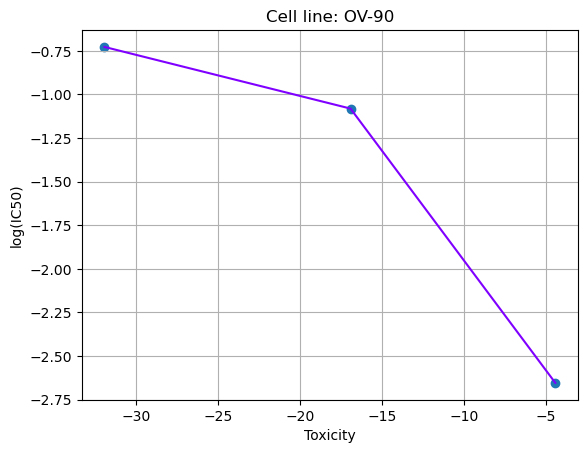

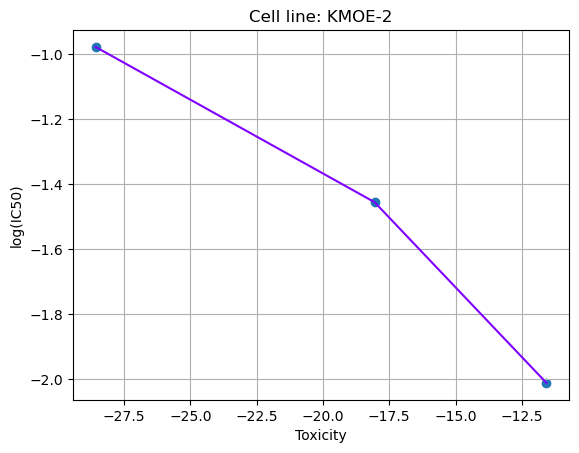

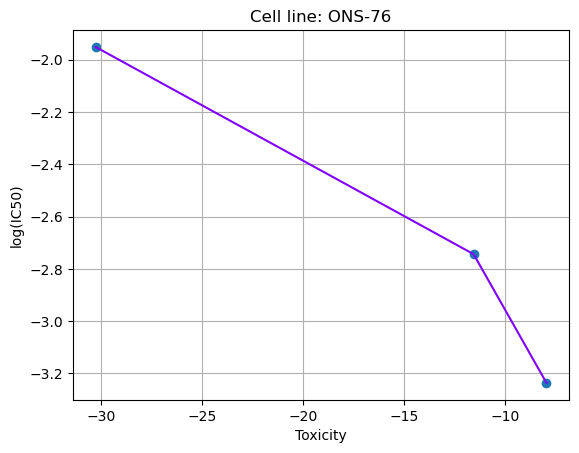

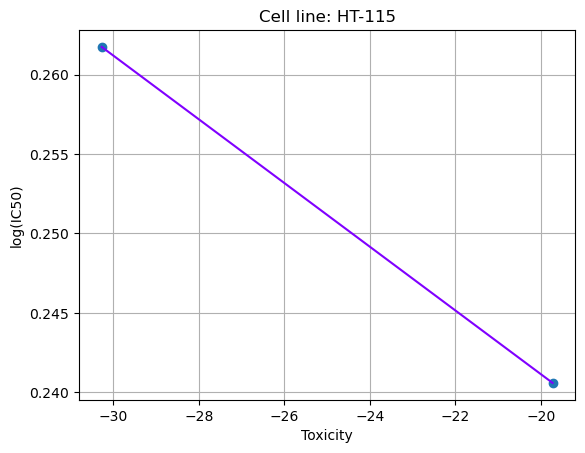

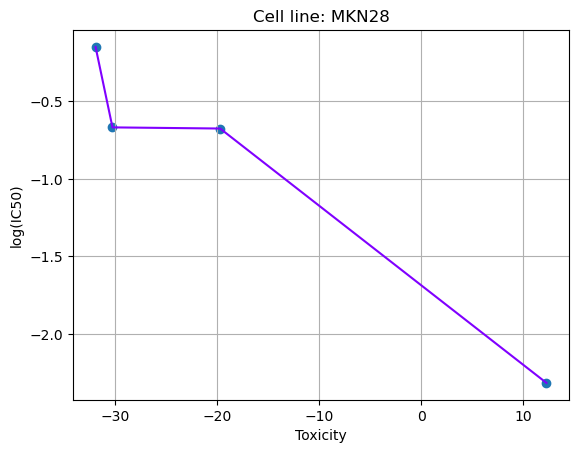

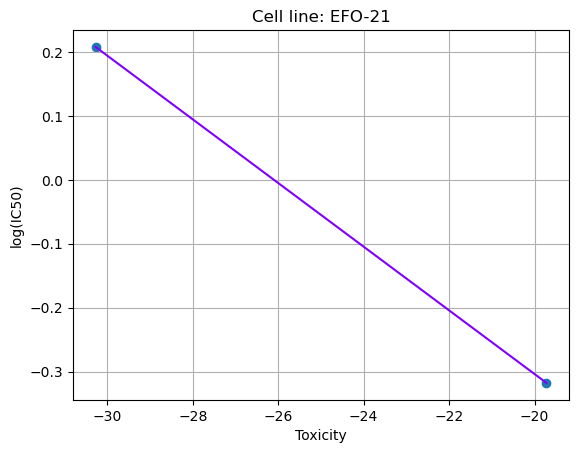

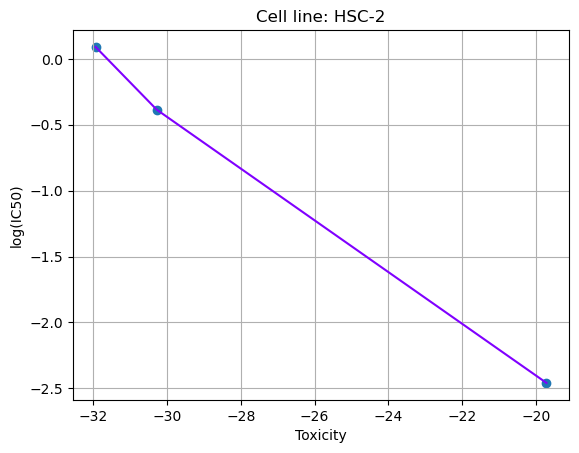

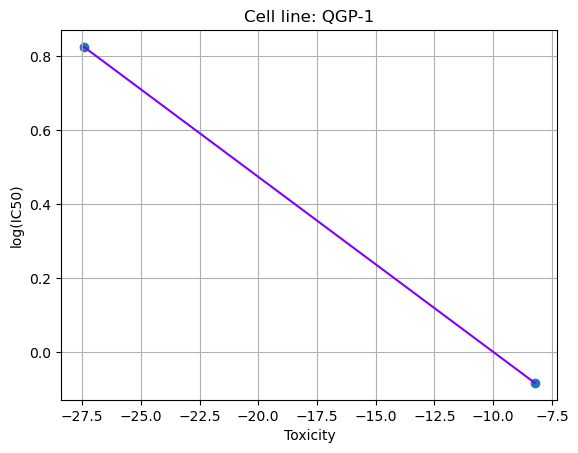

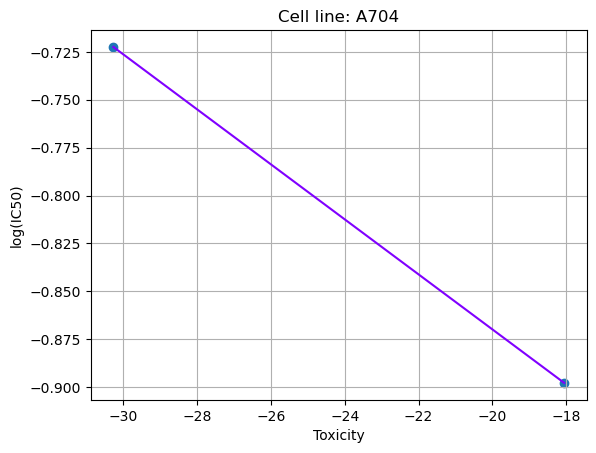

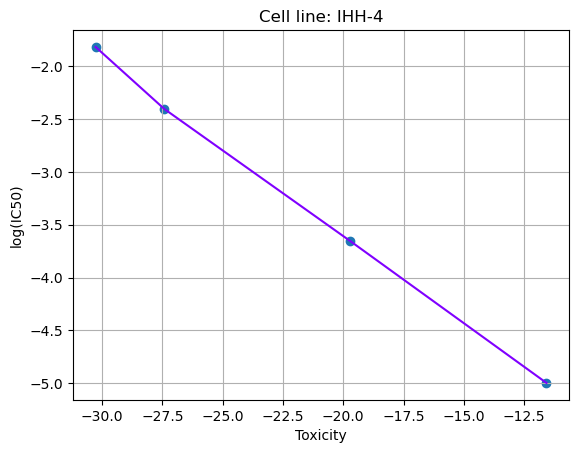

In [12]:
import copy
import matplotlib.cm as cm
import random

num_iter=5
colors = cm.rainbow(np.linspace(0, 1, num_iter))
DrugPipeline = MediSeeker(mTox, mIC50=m, mGen=mGen, cell_line_names=list(df_cell_line['Cell Line_ID'])[601:700], \
                           num_drug_candidates_per_cell_line=10, smiles_batch_size=128, smiles_vocab=vocab)
# for loop:
color_idx=['r','g','b','y','c']
pareto_list=[]
drugs_to_consider_history =[]
sources_history=[]

for i,col in zip(range(num_iter), colors):
    print("Iteration",i+1)
    herg_resp, results= DrugPipeline.predict_herg_IC50(smiles_dl, cell_line_dl)
    candidate_dict=DrugPipeline.getSortedCandidates(herg_resp, results)
   # print(candidate_dict.keys())
   # print(candidate_dict['HCC2998'].keys())
    candidates = copy.deepcopy(candidate_dict)
    DrugPipeline.updateParetoPoints(candidate_dict)
    pareto_dict=DrugPipeline.getParetoPoints()
    pareto_dict2= copy.deepcopy(pareto_dict)
    pareto_list.append(pareto_dict2)
    # Visualize pareto
    for idx,cell_line in enumerate(pareto_dict):
        #print(pareto_dict[cell_line])
        if idx< 10:# =='SNU-407':
        #if cell_line == 'KE-37':
            #print("Figure idx", idx)
            plt.figure(idx)
            plt.xlabel('Toxicity')
            plt.ylabel('log(IC50)')
            plt.title("Cell line: "+cell_line)
            plt.plot(*zip(*pareto_dict[cell_line].values()), color=col)
            plt.scatter(*zip(*pareto_dict[cell_line].values()))
            plt.grid(True)

    new_drug_candidates, source_info = DrugPipeline.generateNewDrugs()
    #print("New drugs", new_drug_candidates)
    # Now flatten dict into list of drugs
    drugs_to_consider=[]
    #sources =[]
    for cell_line in new_drug_candidates:
        drugs_to_consider = drugs_to_consider + new_drug_candidates[cell_line]
    #    sources = sources + source_info[cell_line]
    print("Drugs to consider", len(drugs_to_consider))
   # random.shuffle(drugs_to_consider)
   # drugs_to_consider_history.append(drugs_to_consider)
   # sources_history.append(sources)
    #drugs_to_consider = 
    smiles_dl = DrugPipeline.prepare_drug_data(drugs_to_consider)
plt.show()

In [ ]:
#print(pareto_list[0].keys())
import math
cell_line = 'MOLP-8'
for cell_line in pareto_list[0]:
    if cell_line == 'CADO-ES1':
        IC50 =[]
        Tox=[]
        for idx in range(len(pareto_list)):
            pareto_dict = pareto_list[idx][cell_line]
            IC50.append(list(pareto_dict.values())[0][1])
            Tox.append(list(pareto_dict.values())[0][0])

        delta_IC50 =[-IC50[k] + IC50[0] for k in range(1,len(IC50))]
        delta_Tox =[-Tox[k] + Tox[0] for k in range(1,len(IC50))]
        if (len(set(delta_IC50))> 0):
            print(IC50)
            delta_IC50_lin = [math.exp(k) for k in delta_IC50]
            plt.semilogy(delta_Tox,delta_IC50_lin)
            plt.semilogy(delta_Tox, delta_IC50_lin,'.')
            plt.xlabel('Toxicity reduction (%)')
            plt.ylabel('IC50 reduction ratio')
            ax = plt.gca()
            ax.set_xlim([0, 1.2])
            ax.set_ylim([1, 1.1*max(delta_IC50_lin)])
            plt.grid()
            plt.title('Pareto improvement for lowest toxicity drug - Cell line: '+cell_line)
            plt.show()

            plt.plot(list(range(1,len(delta_IC50_lin)+1)),delta_IC50_lin)
            plt.plot(list(range(1,len(delta_IC50_lin)+1)),delta_IC50_lin,'.')
            plt.xlabel('Iteration')
            plt.ylabel('IC50 reduction ratio')
            ax = plt.gca()
            ax.set_ylim([1, 1.1*max(delta_IC50_lin)])
            plt.grid()
            plt.title('Pareto improvement for lowest toxicity drug - Cell line: '+cell_line)
            
            plt.show()





In [ ]:
    colors = cm.rainbow(np.linspace(0, 1, num_iter))
    for cnt,(pareto_dict, col) in enumerate(zip(pareto_list,colors)):
        print("cnt", cnt)
        for idx,cell_line in enumerate(pareto_dict):
            if cell_line in ['639-V', 'NCI-H1648']:
            #print(pareto_dict[cell_line])
             if idx< 200:# =='SNU-407':
                #print("Figure idx", idx)
                plt.figure(idx)
                plt.xlabel('Toxicity')
                plt.ylabel('log(IC50)')
                plt.title("Cell line "+cell_line)
                plt.plot(*zip(*pareto_dict[cell_line].values()), color=col)
                plt.scatter(*zip(*pareto_dict[cell_line].values()), label='_nolegend_')
                plt.grid(True)
                plt.legend(['iteration 0','iteration 1', 'iteration 2','iteration 3'])
#    plt.figure(1)
#    plt.legend(['iteration 0','iteration 1', 'iteration 2','iteration 3'])
    plt.show()

In [ ]:
from difflib import get_close_matches, ndiff
from rdkit.Chem import Draw 
#'CAL-78', 'SN12C', 'NCI-H720', 'TE-15', 'Hs-633T', 'OVTOKO', 'NCI-H2196', 'CESS',OC-314 JURL-MK1
cell_line =

#'CESS' #'JHH-7' # 'SK-N-SH'
# TE-15 -=> Esophagus cancer
# CADO-ES1 => Ewing Sarcoma (Bone Cancer)

#'PC-3', 'SW872', 'MDA-MB-231'
#'MEG-01', 'CADO-ES1', 'K-562', 'SU8686'
best_drug = []
print(len(pareto_list))
print('Cell line', cell_line)
print(list(pareto_list[0].keys()))
for idx in range(len(pareto_list)):
    #print('keys', list(pareto_list[idx][cell_line].keys())[0])
    best_drug.append(list(pareto_list[idx][cell_line].keys())[0])


for i,drug in enumerate(best_drug):
    #print(drug)
    #For drug find match in GDSC1 drugs:
    res = get_close_matches(drug, drug_candidates_source)
    print("Iteration", i)
    print("DRG",  drug)
    print("REF", res[0])
    # Now get name of drug in ref
    print(df[df['Drug']==res[0]].iloc[0]['Drug_ID'])
    mlist=[]
    m = Chem.MolFromSmiles(drug)
    mlist.append(m)
    m = Chem.MolFromSmiles(res[0])
    mlist.append(m)
    img=Draw.MolsToGridImage(mlist,molsPerRow=4,subImgSize=(300,300))    
    display(img)


In [ ]:
#print(pareto_list[0].keys())
import math


gen1 = pareto_list[0]
gen3 = pareto_list[3]
delta_ic50_dict = {}
gen3_ic50_dict = {}
for k in gen1.keys():
    m = gen1[k]
    n = gen3[k]
    delta_ic50 = m[list(m.keys())[0]][1] - n[list(n.keys())[0]][1]

    delta_ic50_dict[k] = delta_ic50
delta_ic50_dict_sorted = OrderedDict(sorted(delta_ic50_dict.items(), key=lambda item: item[1]))

a = list(delta_ic50_dict_sorted.values())[70:]
new_lst = []
for element in a:
    new_lst.append(math.exp( element ))
    
plt.plot(new_lst) 
x_ticks_labels = list(delta_ic50_dict_sorted.keys())[70:]
ax = plt.gca()
ax.set_ylim([1, 400])
x = np.arange(0,30,1)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=7)

plt.xlabel('Cell Lines')
plt.ylabel('Reduction in drug dosage') 
plt.title('Drug dosage improvement (selected cell lines)')

plt.grid(axis='y')
plt.show()

In [ ]:
#    print(pareto_dict[cell_line])
# Plotting chemicals
cl = list(pareto_dict.keys()) 
print(cl)
cl=['639-V']
d1 = list(pareto_dict[cl[2]].keys())
print(d1)
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
mlist=[]
for idx, drug in enumerate(d1):
    m = Chem.MolFromSmiles(drug)
    mlist.append(m)

print("Num drugs", len(d1))
#print(smiles_to_iupac('c1ccccc1'))
#print(smiles_to_iupac('C[C@@H](C(=O)N[C@@H](C1CCCCC1)C(=O)N2CCC[C@H]2C(=O)N[C@@H]3[C@@H](OC4=CCOCC=C34)OCC#CC#CCO[C@@H]5CC6=CC=CC=C6[C@@H]5NC(=O)[C@@H]7CCCN7C(=O)[C@H](C8CCCCC8)NC(=O)[C@H](C)NC)NC'))
img1 = Draw.MolToImage(mlist[0],size=(400, 400))    
display(img1)
img=Draw.MolsToGridImage(mlist,molsPerRow=4,subImgSize=(300,300))    
display(img)


In [ ]:
cl = list(pareto_dict.keys()) 
print(cl)
cl=['NCI-H1648']
d1 = list(pareto_dict[cl[0]].keys())
#print(drugs_to_consider_history[2][10:15])
#print(drugs_to_consider_history[2][15])
#print(d1[0])
print(len(drug_candidates_source))
from difflib import get_close_matches
res = get_close_matches(d1[0], drug_candidates_source)
print("DRG",  d1[0])
print("REF", res[0])
m = Chem.MolFromSmiles(d1[0])
img1 = Draw.MolToImage(m,size=(400, 400))    
display(img1)
m = Chem.MolFromSmiles(res[0])
img2 = Draw.MolToImage(m,size=(400, 400))    
display(img2)

In [ ]:
lst = (list(df_cell_line['Cell Line_ID']))
lst.index('LK-2')